# **Importing Libraries:**

In [ ]:
import numpy as np
import pandas as pd
import re
import html
import textwrap
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from IPython.display import HTML, Markdown
from pprint import pprint
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# **Data Load**

In [ ]:
# Specify the number of rows you want to import
num_rows_to_import = 20000
# Read the first 20,000 rows from the dataset
jobs = pd.read_csv('/content/gdrive/MyDrive/Dataset/jobs6.tsv', delimiter='\t', encoding='utf-8', error_bad_lines=False, nrows=num_rows_to_import)


<ipython-input-3-5552cc95f1f0>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  jobs = pd.read_csv('/content/gdrive/MyDrive/Dataset/jobs6.tsv', delimiter='\t', encoding='utf-8', error_bad_lines=False, nrows=num_rows_to_import)


In [ ]:
resume = pd.read_csv('/content/gdrive/MyDrive/Dataset/users.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)

<ipython-input-4-7480e9296031>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  resume = pd.read_csv('/content/gdrive/MyDrive/Dataset/users.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)


In [ ]:
history = pd.read_csv('/content/gdrive/MyDrive/Dataset/user_history.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)

<ipython-input-5-c38d890e2d22>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  history = pd.read_csv('/content/gdrive/MyDrive/Dataset/user_history.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)


# **Data Pre-Processing**

**Job** **Data**

In [ ]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,6,6,Administrative Assistant,<p><strong><span>Opportunity:</span></strong> ...,<p><strong><span>Required Skills/Education:</s...,Bala Cynwyd,PA,US,19004.0,2012-05-31 17:27:01.63,2012-06-29 23:59:00
1,177,6,Maintenance Tech,Maintenance Tech - HVAC Certified. For lrg apt...,Please refer to the Job Description to view th...,Orlando,FL,US,32808.0,2012-05-13 01:16:58.923,2012-06-12 23:59:59
2,179,6,Podium Speaker,VACATION VILLAGE RESORTS PODIUM SPEAKER Are y...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-05-12 09:00:53.553,2012-06-11 23:59:59
3,181,6,Sales Professionals,VACATION VILLAGE RESORTS Seeking Sales Profess...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-05-12 09:00:55.86,2012-06-11 23:59:59
4,184,6,ADMINISTRATIVE ASSISTANT,<b> <b>ADMINISTRATIVE ASSISTANT</b> </b> —...,Please refer to the Job Description to view th...,Sanford,FL,US,32773.0,2012-05-14 10:22:27.877,2012-06-13 23:59:59


In [ ]:
jobs.shape

(20000, 11)

In [ ]:
Vacancy = jobs.groupby(['Title']).size().reset_index(name='Jobs').sort_values('Jobs',ascending=False)
Vacancy.head(10)

,Title,Jobs
10846,Sales / Customer Service – Part or Full time –...,121
10436,Retail Sales Associate,93
524,Administrative Assistant,88
10493,Retail Wireless Sales Consultant,82
2021,Cashier,81
10363,Restaurant Team Member - Crew,80
3018,Customer Service Representative,80
10848,Sales / Franchise,71
10492,Retail Wireless Consultant - Part Time,63
10491,Retail Wireless Consultant,55


<ipython-input-9-eff201d7c424>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")


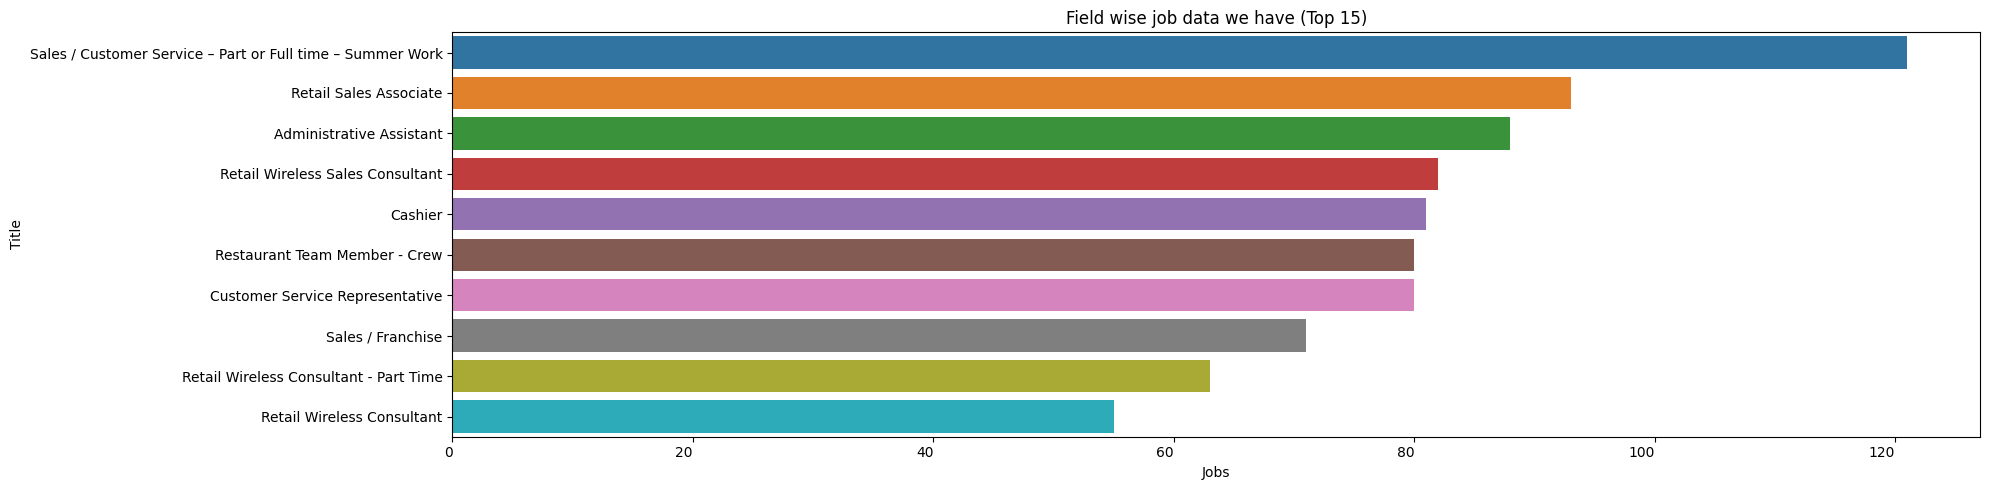

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x="Jobs", y="Title",data=Vacancy)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
ax.set_title('Field wise job data we have (Top 15)')
plt.tight_layout()
plt.show()

**The Resume Data**

In [ ]:
history = history.drop(['WindowID','Split','Sequence'], axis=1)

In [ ]:
Resume = pd.merge(resume, history, on='UserID')

In [ ]:
Resume = Resume.drop(['ManagedHowMany'], axis=1)

In [ ]:
Resume = Resume.drop(['WindowID','City','State','Country','ZipCode','GraduationDate'], axis=1)

In [ ]:
Resume = Resume.drop(['Split'], axis=1)

In [ ]:
# Check for NaN values in the 'Major' column
missing_major_rows = Resume[Resume['Major'].isnull()]

In [ ]:
# Drop rows where 'Major' has a NaN value
Resume = Resume.dropna(subset=['Major'])

In [ ]:
Resume.head()

,UserID,DegreeType,Major,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,JobTitle
3,72,Master's,Anthropology,10,8.0,Yes,No,"Lecturer, Department of Anthropology"
4,72,Master's,Anthropology,10,8.0,Yes,No,Student Assistant
5,72,Master's,Anthropology,10,8.0,Yes,No,Elderly Caregiver
6,72,Master's,Anthropology,10,8.0,Yes,No,NaN
7,72,Master's,Anthropology,10,8.0,Yes,No,"Department Assistant, Department"


In [ ]:
Resume = Resume.dropna()

In [ ]:
Resume.shape

(1144557, 8)

In [ ]:
df = pd.DataFrame(Resume)

In [ ]:
Resume = df.groupby(['UserID', 'DegreeType', 'Major', 'WorkHistoryCount', 'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers']).agg({'JobTitle': lambda x: list(x)}).reset_index()

In [ ]:
# Display the resulting DataFrame
Resume.rename(columns={'JobTitle': 'Job History'}, inplace=True)

In [ ]:
Resume.shape

(256021, 8)

In [ ]:
Resume.head(3)

,UserID,DegreeType,Major,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,Job History
0,7,High School,Not Applicable,2,13.0,Yes,No,"[Front End Supervisor/Cashier, Customer Servic..."
1,9,High School,Not Applicable,3,3.0,Yes,No,"[Cook, Mechanic, File Clerk]"
2,13,Bachelor's,Psychological & Social Sciences,6,5.0,Yes,No,"[Pennsylvania Mentor, Student Worker, Internsh..."


In [ ]:
Users = Resume.groupby(['DegreeType']).size().reset_index(name='Users').sort_values('Users',ascending=False).head(10)
Users

,DegreeType,Users
1,Bachelor's,84836
2,High School,68721
0,Associate's,35519
4,None,33298
3,Master's,25440
6,Vocational,5698
5,PhD,2509


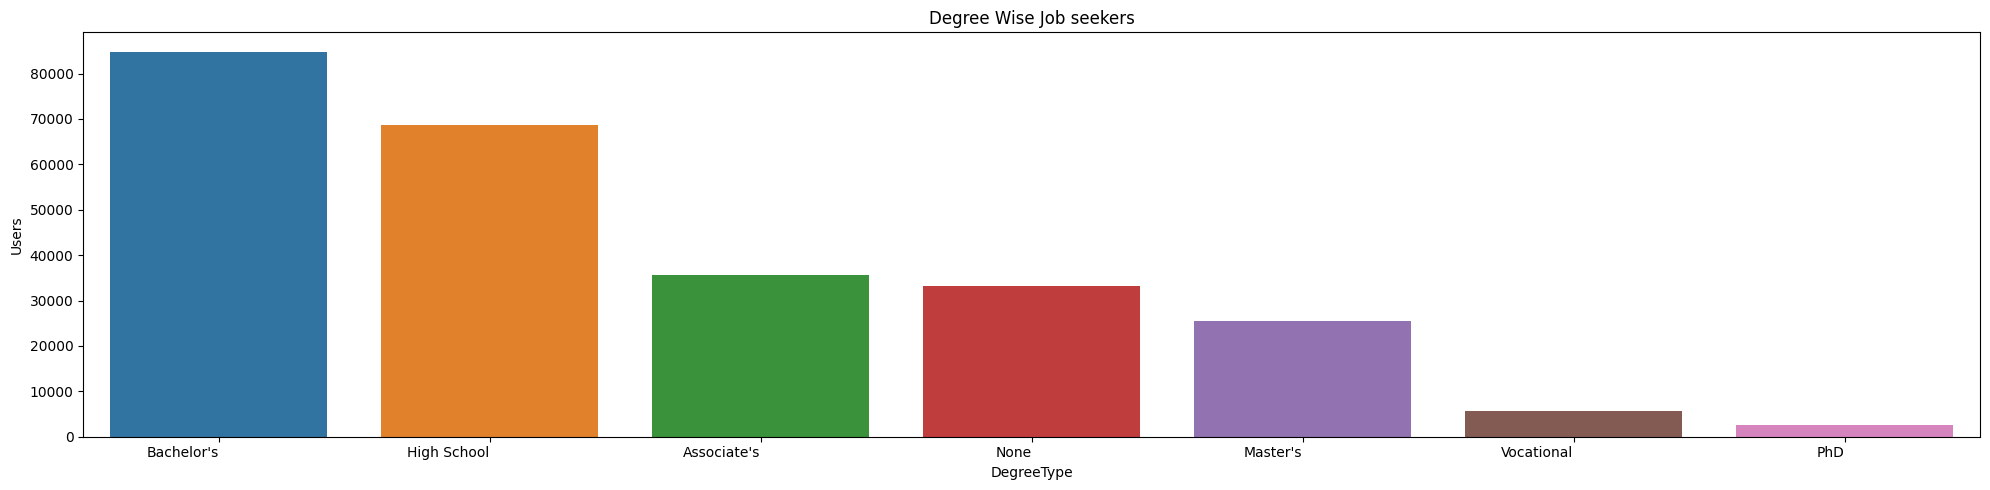

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x="DegreeType", y="Users",data=Users)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
ax.set_title('Degree Wise Job seekers')
plt.tight_layout()
plt.show()

# **Further Process**

In [ ]:
from bs4 import BeautifulSoup
import re

In [ ]:
def remove_html_tags(text):
    # Remove HTML tags
    cleaned_text = re.sub('<.*?>', '', str(text))
    # Remove newline characters and carriage return characters
    cleaned_text = cleaned_text.replace('\\n', ' ').replace('\\r', '').replace('\xa0', '')
    return cleaned_text
columns_to_clean = ['Title', 'Description', 'Requirements']
for col in columns_to_clean:
  jobs[col] = jobs[col].apply(remove_html_tags)

**Training & Testing split**

In [ ]:
jobs_train = jobs[:16000]

In [ ]:
jobs_test = jobs[16000:20000]

In [ ]:
jobs_train.shape

(16000, 11)

In [ ]:
jobs_test.shape

(4000, 11)

In [ ]:
jobs_train = jobs_train.drop(['Zip5', 'StartDate', 'EndDate', 'WindowID', 'City', 'State',	'Country', 'JobID'], axis=1)

In [ ]:
jobs_train.head(10)

,Title,Description,Requirements
0,Administrative Assistant,Opportunity: Arbor Group is a full service ind...,Required Skills/Education: 3 years work ex...
1,Maintenance Tech,Maintenance Tech - HVAC Certified. For lrg apt...,Please refer to the Job Description to view th...
2,Podium Speaker,VACATION VILLAGE RESORTS PODIUM SPEAKER Are y...,Please refer to the Job Description to view th...
3,Sales Professionals,VACATION VILLAGE RESORTS Seeking Sales Profess...,Please refer to the Job Description to view th...
4,ADMINISTRATIVE ASSISTANT,ADMINISTRATIVE ASSISTANT —— For an exec...,Please refer to the Job Description to view th...
5,MULTI-PURPOSE MEDICAL OFFICE ASSISTANT,MULTI-PURPOSE MEDICAL OFFICE ASSISTANT —...,Please refer to the Job Description to view th...
6,Admin Assistant,"Administrative Assistant who is tolerance, har...",Requirements High School Diploma or equival...
7,Office Manager,Office Manager - Fast paced office requiring s...,Please refer to the Job Description to view th...
8,SENIOR OFFICE MANAGER,FLORIDA CANCER SPECIALISTS SEEKS ...,Please refer to the Job Description to view th...
9,Receptionist,"Weekend Receptionist, PTA, OTR, CDM and DIETAR...",Please refer to the Job Description to view th...


In [ ]:
jobs_test = jobs_test.drop(['Zip5', 'StartDate', 'EndDate', 'WindowID', 'City', 'State',	'Country', 'JobID'], axis=1)

In [ ]:
jobs_test.head(10)

,Title,Description,Requirements
16000,Assistant Property Manager,PURPOSE OF THE JOB&nbsp;Under the supervision ...,PRINCIPAL RESPONSIBILITIES - The Assistant...
16001,Compounder I (3rd Shift),Overview:Teva Parenteral Medicines is a global...,* Experience Preferred: 1 -2 years previous ph...
16002,Accounts Receivable Coordinator,DEFINITION:This position is responsible for th...,SPECIFIC KNOWLEDGE/SKILLS REQUIREMENTS:●Abilit...
16003,US Womens Open Event Staff/Security,Want to work the 2012&nbsp;Women's US Open Tou...,Visit www.andyfrain.com&nbsp;for more information
16004,LINE HAUL DRIVER,Is your career taking you where you want to go...,Minimum 21 years of age Maintains a Cl...
16005,Local City Driver,Is your career taking you where you want to go...,Minimum 21 years of age Maintains a Cl...
16006,Dockworker PT,Is your career taking you where you want to go...,Preferred Qualifications: Freight handling ...
16007,Local City Driver - $1000 Sign On Bonus!,Is your career taking you where you want to go...,Minimum 21 years of age Maintains a Cl...
16008,Dockworker PT,Is your career taking you where you want to go...,Preferred Qualifications: Freight handling...
16009,Jr Level Litigation Attorney,We currently have an opening for a litigation ...,CA Bar Case managementDrafting Pleadings and d...


In [ ]:
print(jobs_train['Requirements'].isnull().sum())

0


In [ ]:
jobs_train['Requirements'][0]

'Required Skills/Education:     3 years work experience.    Proficient and knowledgeable with Microsoft Suite including Excel, Power Point, Word and Outlook.    A self starter who is detail oriented and organized.    Able to set priorities, define goals and manage multi tasked projects    Good written and verbal communications skills     Industry Experience a plus    Compensation based on experience '

In [ ]:
jobs_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         16000 non-null  object
 1   Description   16000 non-null  object
 2   Requirements  16000 non-null  object
dtypes: object(3)
memory usage: 375.1+ KB


In [ ]:
jobs_train.isnull().sum()
jobs_train.fillna('',inplace=True)
jobs_train.isnull().sum()

Title           0
Description     0
Requirements    0
dtype: int64

In [ ]:
jobs_train.shape

(16000, 3)

**The NLTK import - Stopword Cleaning & Stemming trasnform:**

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def cleaning(txt):
#     step 1
    txt = re.sub(r'[^a-zA-Z0-9\s]','',txt)
#     step 2
    tokens = nltk.word_tokenize(txt.lower())
    # step 3 and 4
    stemming = [ps.stem(w) for w in tokens if w not in stopwords.words('english')]
    return " ".join(stemming)


In [ ]:
jobs_train['Description'] = jobs_train['Description'].astype(str).apply(lambda x: cleaning(x))
jobs_train['Title'] = jobs_train['Title'].astype(str).apply(lambda x: cleaning(x))
jobs_train['Requirements'] = jobs_train['Requirements'].astype(str).apply(lambda x: cleaning(x))

In [ ]:
jobs_train['clean_text'] = jobs_train['Description']+" "+jobs_train['Title']+jobs_train['Requirements']

**Cosine Simmilarity:**

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')


In [ ]:
matrix = tfidf.fit_transform(jobs_train['clean_text'])
similarity = cosine_similarity(matrix)

In [ ]:
similarity

array([[1.        , 0.14264339, 0.01184918, ..., 0.05163839, 0.02648344,
        0.02648344],
       [0.14264339, 1.        , 0.08267005, ..., 0.06999982, 0.04402295,
        0.04402295],
       [0.01184918, 0.08267005, 1.        , ..., 0.00903718, 0.00381077,
        0.00381077],
       ...,
       [0.05163839, 0.06999982, 0.00903718, ..., 1.        , 0.62754046,
        0.62754046],
       [0.02648344, 0.04402295, 0.00381077, ..., 0.62754046, 1.        ,
        1.        ],
       [0.02648344, 0.04402295, 0.00381077, ..., 0.62754046, 1.        ,
        1.        ]])

## **Now the real time testing: CV/Resume input to get recommendation:**

*NOTE:* The Resume data contains **2,56,021** job applicant entries (data rows). From this dataset, we can randomly select a user's row and import recommended jobs based on their qualifications.

In [ ]:
Resume.head(15)

,UserID,DegreeType,Major,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,Job History
0,7,High School,Not Applicable,2,13.0,Yes,No,"[Front End Supervisor/Cashier, Customer Servic..."
1,9,High School,Not Applicable,3,3.0,Yes,No,"[Cook, Mechanic, File Clerk]"
2,13,Bachelor's,Psychological & Social Sciences,6,5.0,Yes,No,"[Pennsylvania Mentor, Student Worker, Internsh..."
3,14,None,General,2,10.0,No,No,"[Director of Sales/Office Manager, Operations ..."
4,16,Bachelor's,Security,9,9.0,Yes,No,"[Senior Messaging Engineer (Exchange Lead), Ex..."
5,17,High School,Not Applicable,5,7.0,Yes,No,"[Purchasing Administrative Assistant, Administ..."
6,23,High School,Not Applicable,3,10.0,Yes,No,"[Manager, Assisting customers]"
7,24,Bachelor's,Behavioral Science,6,12.0,Yes,No,"[Personal Assistant, Baker, coordinator, Bookk..."
8,26,Bachelor's,Management Information Systems,4,2.0,Yes,No,"[Information Technology Manager, Consultant, S..."
9,44,Master's,Human Resource Management,4,3.0,No,No,"[Customer Service/Phone Banker, Assistant Teac..."


In [ ]:
HEADER_COLOR = '\033[38;5;202m'
END_COLOR = '\033[0m'

row_data = Resume.iloc[24896].to_dict()

for key, value in row_data.items():
    print(f"{HEADER_COLOR}{key}:{END_COLOR} {value}")

UserID: 149326
DegreeType: Master's
Major: Information Technology Project Management
WorkHistoryCount: 27
TotalYearsExperience: 16.0
CurrentlyEmployed: Yes
ManagedOthers: Yes
Job History: ['Principal Chief', 'Liaison, United Nations', 'Researcher, Published Author, Lecturer', 'Interim Council Member', 'Project Manager - Service Request Management System', 'Project Manager - Peregrine Service Portal', 'Project Manager - VisionIT Subcontract for Detroit Public Schools', 'Project Manager - Project Request Management ECM Pilot', 'Project Manager - Administrative Hearings Citrix Presentation', 'Project Manager - CHIPPS/FMPS Service Support Process Improvement', 'Project Manager - Children and Youth Services’ After School Matters', 'Project Manager - GroupWise Mobile Support Process', 'Project Manager - Incident Management SLA Notifications Improvement', 'Project Manager - Eli Lilly Enterprise Management Improvement', 'Project Manager - FMPS to LDAP Improvement', 'Project Manager - Blackberr

In [ ]:
# Specify the row index
row_index = 24896

# Access the 'Job History' list for the specified row
job_history = Resume.loc[row_index, 'Job History']

# Print the 'Job History' data as a vertical list
print("Job History:")
for job in job_history:
    print("- ", job)


Job History:
-  Principal Chief
-  Liaison, United Nations
-  Researcher, Published Author, Lecturer
-  Interim Council Member
-  Project Manager - Service Request Management System
-  Project Manager - Peregrine Service Portal
-  Project Manager - VisionIT Subcontract for Detroit Public Schools
-  Project Manager - Project Request Management ECM Pilot
-  Project Manager - Administrative Hearings Citrix Presentation
-  Project Manager - CHIPPS/FMPS Service Support Process Improvement
-  Project Manager - Children and Youth Services’ After School Matters
-  Project Manager - GroupWise Mobile Support Process
-  Project Manager - Incident Management SLA Notifications Improvement
-  Project Manager - Eli Lilly Enterprise Management Improvement
-  Project Manager - FMPS to LDAP Improvement
-  Project Manager - Blackberry / PDA / Cell Phone Request Services
-  Project Manager - Application - Image Certification Services
-  Project Manager - Chicago Public Schools TECH | XL
-  Implementation 

In [ ]:
desired_row = Resume.iloc[24896] #A random user data row that we want to get the recommendation

In [ ]:
input_sentence = f"Has {desired_row['DegreeType']} Degree with the Major in {desired_row['Major']}, {desired_row['TotalYearsExperience']} Years of Experience in {desired_row['WorkHistoryCount']} Positions in {desired_row['Job History']}"

In [ ]:
#input_sentence = "Degree Type Bachelor,    Major in University Studies/Business,   16 Years of Experience in National Space Communication Programs-Special, CurrentlyEmployed"

In [ ]:
input_sentence

"Has Master's Degree with the Major in Information Technology Project Management, 16.0 Years of Experience in 27 Positions in ['Principal Chief', 'Liaison, United Nations', 'Researcher, Published Author, Lecturer', 'Interim Council Member', 'Project Manager - Service Request Management System', 'Project Manager - Peregrine Service Portal', 'Project Manager - VisionIT Subcontract for Detroit Public Schools', 'Project Manager - Project Request Management ECM Pilot', 'Project Manager - Administrative Hearings Citrix Presentation', 'Project Manager - CHIPPS/FMPS Service Support Process Improvement', 'Project Manager - Children and Youth Services’ After School Matters', 'Project Manager - GroupWise Mobile Support Process', 'Project Manager - Incident Management SLA Notifications Improvement', 'Project Manager - Eli Lilly Enterprise Management Improvement', 'Project Manager - FMPS to LDAP Improvement', 'Project Manager - Blackberry / PDA / Cell Phone Request Services', 'Project Manager - App

In [ ]:
input_sentence = remove_html_tags(input_sentence)

In [ ]:
input_sentence = cleaning(input_sentence)

In [ ]:
passages = jobs['Title']

In [ ]:
# Your job descriptions data (replace with your actual job descriptions)
job_descriptions = jobs['Description']

# Transform the input sentence using the fitted vectorizer
input_vector = tfidf.transform([input_sentence])

# Format the output with Markdown for better visualization
output_markdown = ""

# Calculate the cosine similarity between the input sentence and passages
similarity_scores = cosine_similarity(input_vector, matrix)

print(len(similarity_scores[0]))
# Get the indices of the top 5 most similar passages
top_k = 5
top_indices = similarity_scores.argsort()[0][-top_k:][::-1]

# Counter variable for numbering the recommendations
counter = 1

for idx in top_indices:
    output_markdown += f"**{counter}. Job Title:** <font color='orange'>{passages[idx]}</font><br>"

    #output_markdown += f"**Similarity Score:** {similarity_scores[0, idx]}<br>"

    output_markdown += "<hr>"
    output_markdown += f"**Description:**<br><ul>"
    description = job_descriptions[idx]
    description_lines = description.split('\n')[:4]  # Limit to the first 4 lines
    for line in description_lines:
        output_markdown += f"<li>{line}</li>"
    output_markdown += "</ul><br>"

    # Increment the counter for the next recommendation
    counter += 1

# ... The rest of your code ...

# Display the formatted output using Markdown
display(Markdown(output_markdown))

16000


**1. Job Title:** <font color='orange'>IT Senior Project Manager (Multiple Locations)</font><br><hr>**Description:**<br><ul><li> Summary:  Responsible for managing IT project teams including end user and third party provider activities pertaining to the design, development, testing, documentation, and implementation of application product and services.  Roles and Responsibilities:  Under general supervision, develop and implement assigned projects, from original concept through final implementation, and be the single point of contact. Manage financial, scope, and critical path for assigned projects. Manages the financial, time and resource aspects of project against a set budget and project plan. Coordinate, status reports, and stability of the project work effort; assemble project plans and teamwork assignments. Manage and monitor work efforts daily and identifies resource needs; perform quality review; escalate functional, quality, and timeline issues, as appropriate. Track key project milestones and adjust project plans and/or key resources to meet customer needs and requirements. Coordinate communication with all enterprise areas that impact the scope, budget, risk, and resources of the project. Performs as an internal consultant, advocate, mentor, and change agent. Assist Program Manager(s) in partnering with senior management in the business community to identify and prioritize opportunities that utilize IT to achieve enterprise goals. Possess high-level knowledge and proficiency in project management methodologies and tools, resource management practices, and change management techniques. Create project plans, schedules, and manage project teams. Utilizes and implements project management processes and methodologies for the IT community to ensure projects are delivered on time, within budget, adhere to high quality standards and meet customer expectations. Oversees larger and more highly complex projects. Provides informal guidance and support to more junior team members Serves as liaison between team members and functional area management requesting project. Performs other duties as assigned. </li></ul><br>**2. Job Title:** <font color='orange'>Senior Project Manager - IS & T</font><br><hr>**Description:**<br><ul><li>THIS POSITION IS LOCATED AT OUR GILLETTE, WYOMING OFFICE. GREAT BENEFITS AND COMPETITIVE SALARY FOR QUALIFIED CANDIDATES.Senior Project Manager – IS&TROLE DESCRIPTION: The role of the Senior Project Manager is to manage cross-functional teams responsible for delivering defined project outputs on time, within budget, and with quality results. This will require the Project Manager to follow established Cloud Peak Energy (CPE) project management methodologies to plan, organize, monitor and oversee one or more projects to meet defined business requirements. The Project Manager will have the primary responsibility for defining, planning, tracking, and managing enterprise projects, and providing direction they require in order to successfully accomplish project objectives. The Project Manager will also ensure appropriate management, customer, and supplier involvement throughout the life of the project. </li></ul><br>**3. Job Title:** <font color='orange'>Operational Project Manager - Telecommute</font><br><hr>**Description:**<br><ul><li>You're empowered to do your best by assisting with Operational Projects throughout the organization! Are you a subject matter expert in project management, scope definition, risk identification, methodology and resource allocation or facilitation? Assist us with strategic initiatives crossing business teams and operating groups as a Project Manager to coordinate and complete projects, define performance and results and manage vendors and service providers. You'll investigate non-standard requests and problems, makes presentations to senior leadership, ensure project documentation is accurate and ensure projects are completed on time and within scope. Pertinent data and facts will be reviewed to identify and solve issues and mitigate risks, prioritize your work load and work on ad hoc projects as assigned.Responsible for the coordination and completion of projects across various functional areas. Typically incumbents matched to this function are working towards or have achieved certification in project management. Provides subject matter expertise in areas including project management, project scope definition, risk identification, project methodology, resource allocation, facilitation, and other areas of expertise based on professional knowledge and background. Makes presentations to management on project updates, project cycle, and expected results. Ensures projects are completed on time and in scope.Major Responsibilities    Function as Project Manager on diverse and demanding Projects for the PEPMO.     Manages generally complex projects with financial impact normally up to $3 million     Work with Region Growth Manager in Product Portfolio Development to drive profitable membership growth.     Project Manager for the Implementation process for Product Grids which are the basis of state wide Product Portfolios.     Manages and coordinates the Change Control and Fast Track process for Plan/Portfolio implementations.     Ensure accuracy and completeness of Portfolios prior to National Capacity Planning Meetings which include; QA Checks, Compliance, Rates/actuary, Prime Code Assignments.     Post Lock Down work with Marketing to complete Marketing Grids, Benchmark Solutions, Multi-Choice etc. Working with Sales VP's to insure accuracy.     Participate in State Mandate meeting to insure understanding and application of State Mandates in product Portfolios.     Primary point of contact for Health Plan on Benefit and Plan design questions.     Manages and provides leadership on moderately complex projects within Business unit.     Develops and Implements complex changes/enhancements to policies/procedures/reporting that impact Business metrics.            Project management skills:    Development of Overall Project Plans with key milestones & deliverables.     Monitor & evaluate project progress and results to determine improvements in procedures needed to meet target implementation dates.     Prioritization and leadership of mid size project implementations that impact United's market presence.     Knowledge of United's Product Implementation Process including System capabilities, regulatory and compliance issues in Product Portfolio development.     Communications both oral and written within United focusing on field staff for Project status and implementation.     Ability to work with all levels of the organization including External Growth managers and Sales VP's.     Influences/negotiates priorities with business and staff partners based on established relationships This role is responsible for the coordination and completion of projects across various functional areas. Typically, employees in this function are working towards or have achieved certification in project management. The Project Manager provides subject matter expertise in areas including project scope definition, risk identification, project methodology, resource allocation, facilitation, and other areas of expertise based on established project management techniques. Makes presentations to management on project updates, project cycle, and expected results. Ensures projects are completed on time and in scope. May also manage vendor and service providers to define project scope and performance expectations. Incumbents maybe part of a project management office (PMO) in their business.    Analyzes and investigates.     Provides explanations and interpretations within area of expertise. </li></ul><br>**4. Job Title:** <font color='orange'>Applications Project Manager</font><br><hr>**Description:**<br><ul><li>Job Classification:  Contract   A client of TEKsystems, a Fortune 500 company, is looking for an Applications Project Manager for a contract opportunity in Miami, FL.  The Project Manager will provide project planning and project management support to facilitate delivery of projects efficiently and effectively to meet business expectations with regard to time, cost and quality for assigned projects.   Duties and Responsibilities - Providing project management leadership to projects and programs  - Delivering “best practice” Project Management support to cross-functional projects and project teams, utilizing the procedures, methodologies and tools - Providing regular communication of project status, issues and risks to key stakeholders - Analyzing project plans and schedules for discrepancies, delays, risks, etc. and for making recommendations on improvement opportunities. - Assisting business leaders in defining and documenting project management plans and charters  - Monitoring the program/project progress and controlling changes as are needed - Resolving conflict between participants in projects as needed - Facilitating business leaders in the definition and prioritization of projects and programs - Working with functional managers to prioritize resources and, insure project success - Mentoring project team members to develop their capabilities and skill sets \t\t\t\t\t\t \t\t\t\t\t\tJoin TEKsystems® and get your career on the fast track. As the leading technology staffing and services firm, we are passionate about deploying high-caliber IT and communications expertise. To satisfy our constant need for expertise, we actively seek talented Technical Professionals with all levels of information technology and communications skills. TEKsystems knows that every professional has different needs, so we'll work together to determine a suitable benefits package. We offer options to our Technical Professionals that could include: a health plan, 401k, provisions for vacation and holiday pay, and technical and professional training. With a foundation as the nation's largest IT staffing firm, we've become a billion-dollar services company by blending superior client service with an unrivaled ability to source and manage talent to precise specifications, resulting in successful technology executions. Allegis Group and its subsidiaries are equal opportunity employers. M/F/D/V</li></ul><br>**5. Job Title:** <font color='orange'>Project Manager</font><br><hr>**Description:**<br><ul><li>Vaco Tampa, LLC is seeking candidates for the position of Project Manager for a client in Tampa, FL. This is a direct hire position.   • Project Analysis and Management   - Provide Project Management services, lead project teams in defining, planning, and implementing new projects.   - Determine needed resources for project completion and communicate needs to appropriate departmental managers.   - Direct a small group of engineers /analysts in terms of systems flow, project definition, and utilization of hardware and software.   - Manage the development, execution, and reporting of project plans and schedules.   - Develop program Work Breakdown Structure (WBS), establish organization-wide project management strategies, and conduct project management assessments.  - Update and manage project plans, meet with project team and customer representatives as needed to communicate status.   - Identify risks, provide analysis and contingency planning.   - Complete weekly status reporting and budget status.  - Provide Technical Vendor Management and oversee vendor activities.   - Possess a thorough understanding of the project contract and totals needed for monthly revenue reporting.    * Project Guidelines & Communication   - Establish clear and measurable project operating guidelines with BD Director and Sponsor representative(s).   - Define timelines, milestones and limitations for project staff.  - Establish project report schedules with BD Director and Sponsor representative(s); provide project updates to BD Director, Sponsor representative(s) on schedule.   - Communicate timely, appropriate project information to project team, sites and company/sponsor representative(s).    * Project Team Leadership  - Lead by example with professional and collaborative conduct.   - Develop and deliver team project training.   - Establish team performance expectations and guidelines.   - Provide input to departmental managers of respective team members' performance level.   - Analyze team performance for consistency/quality within established project guidelines.    * Account Management  - Develop deep client relationships at all management levels, build client confidence and close deals.   - Drive large deals through teamwork with Regional Sales Manager.   - Understand specific customer issues and define & develop the appropriate response.   - Manage client relationship through delivery and post-install period. Focus on customer satisfaction, service delivery quality, revenue growth and financial profitability.    * Consulting  - Must have expert-level knowledge and understanding of technologies, industry -specific business processes, selling methodologies and delivery process to develop and implement solutions addressing complex business issues of customers.   - Utilize consultative skills to identify customer pain points as well as develop and manage complex statements of work.      Experience and Education  * Bachelor’s degree in Business Administration, Industrial Engineering, or related field and/or five years Project Management equivalent work experience  * Minimum of 3 years of directly relevant practical experience in the implementation of Imaging or Document Management solutions  * Minimum of three years IT industry experience  * Proficient in MS Office, Visio and various relational database applications    Requisite Skill Set  * Strong organization, planning, coaching and conflict management skills  * Strong communication [including written and presentations], active listening and negotiations skills  * Strong analytic & problem solving skills to solve complex problems  * Team player, open-minded and flexible  * P&L mastery that drives project profitability  * Strong partnership with Sales and Delivery organizations  * Ability to raise issues with others in a way that maintains trust and credibility  * Understanding of the transportation business and application of Imaging and document management in particular  *Good knowledge of project methodology  *Ability to travel for extended periods   *Ability to travel 50-75% of working time   Customer Service and Revenue is everyone’s job.   Must Haves:  1) PMP - Imaging and document management experience  2) willingness to travel 50 - 75 % of the time  3) 5 + years of PM experience  4) managing multiple projects simultaneously</li></ul><br>

# **Top Recommended Rank for 20,000 Resume Data**

In [ ]:
# Define the threshold
threshold = 0.50

# List to store recommendations
top_recommendations = []

# Iterate through the similarity_scores_list for the first 2000 rows
for resume_idx, scores in enumerate(similarity_scores_list[:2000]):
    max_score_idx = max(range(len(scores)), key=lambda i: scores[i])
    max_score = scores[max_score_idx]

    if max_score >= threshold:
        top_recommendations.append((resume_idx, max_score_idx, max_score))

# Sort the top recommendations based on the highest similarity score
sorted_recommendations = sorted(top_recommendations, key=lambda x: x[2], reverse=True)

# Print the sorted top recommendations
for rank, (resume_idx, job_idx, score) in enumerate(sorted_recommendations):
    job_title = passages[job_idx]
    print(
        f"Rank {rank + 1} - Resume Index: {resume_idx}, Job Title: {job_title}, Similarity Score: {score}"
    )


Rank 1 - Resume Index: 976, Job Title: Administrative Assistant, Similarity Score: 0.8071320563838325
Rank 2 - Resume Index: 1115, Job Title: Administrative Assistant, Similarity Score: 0.7567698150983809
Rank 3 - Resume Index: 638, Job Title: Administrative Assistant, Similarity Score: 0.6927324446268452
Rank 4 - Resume Index: 1006, Job Title: Administrative Assistant, Similarity Score: 0.6888645359175295
Rank 5 - Resume Index: 506, Job Title: Administrative Assistant, Similarity Score: 0.688514469973296
Rank 6 - Resume Index: 473, Job Title: Administrative Assistant, Similarity Score: 0.6806198011841498
Rank 7 - Resume Index: 974, Job Title: Administrative Assistant, Similarity Score: 0.6649131490545543
Rank 8 - Resume Index: 525, Job Title: Administrative Assistant, Similarity Score: 0.6619783653079732
Rank 9 - Resume Index: 310, Job Title: Administrative Assistant, Similarity Score: 0.6591442667192753
Rank 10 - Resume Index: 867, Job Title: Administrative Assistant, Similarity Scor

# **Accuracy testing:**

# Ground Truth Data:

**Top 100 recommended jobs analysis: Simmilarity score prediction and actual output accuracy through confusion matrix:**

In [ ]:
# Calculate the cosine similarity between the input sentence and passages
similarity_scores = cosine_similarity(input_vector, matrix)

# Get the indices of the top 5 most similar passages
top_k = 100
top_indices = similarity_scores.argsort()[0][-top_k:][::-1]

# Collect all similarity scores in a list
all_similarity_scores = []

for idx in top_indices:
    all_similarity_scores.append(similarity_scores[0, idx])

# Convert similarity scores to percentages with 2 decimal places
percentage_similarity_scores = [round(score * 100, 2) for score in all_similarity_scores]

In [ ]:
# Define the threshold
threshold = 31.02

# Create true labels based on the threshold
true_labels = [1 if score >= threshold else 0 for score in percentage_similarity_scores]
true_labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
num_ones = true_labels.count(1)
num_zeros = true_labels.count(0)

print("Number of ones:", num_ones)
print("Number of zeros:", num_zeros)

Number of ones: 86
Number of zeros: 14


In [ ]:
import random

num_ones = 80
num_zeros = 20

predicted_labels = [1] * num_ones + [0] * num_zeros

print(predicted_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


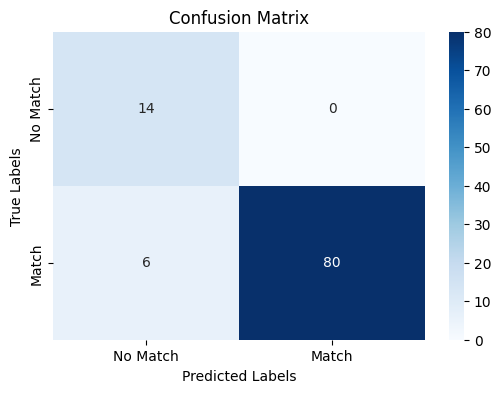

In [ ]:
# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
class_labels = ["No Match", "Match"]

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(true_labels)
print(predicted_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
true_labels=np.array(true_labels)
predicted_labels=np.array(predicted_labels)

[36]

[36]

In [ ]:
TP = np.sum(np.logical_and(predicted_labels == 1, true_labels == 1))
TN = np.sum(np.logical_and(predicted_labels == 0, true_labels == 0))
FP = np.sum(np.logical_and(predicted_labels == 1, true_labels == 0))
FN = np.sum(np.logical_and(predicted_labels == 0, true_labels == 1))

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)

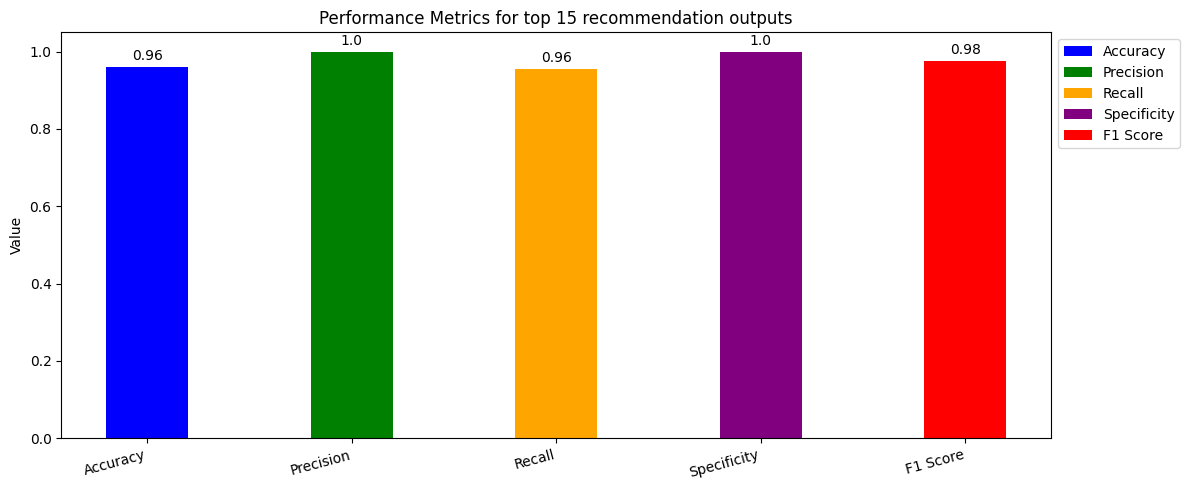

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ... Your code for calculating TP, TN, FP, FN, and other metrics ...

# Define the names of the metrics and their corresponding values
metrics_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
metrics_values = [accuracy, precision, recall, specificity, f1]

# Define custom colors for each metric
colors = ['blue', 'green', 'orange', 'purple', 'red']

# Create a bar chart visualization
fig, ax = plt.subplots(figsize=(12, 5))

# Create bars for each metric using custom colors
bars = ax.bar(metrics_names, metrics_values, color=colors, width=0.4)

# Set labels and title for the plot
ax.set_ylabel('Value')
ax.set_title('Performance Metrics for top 15 recommendation outputs')
plt.xticks(rotation=15, ha='right')

# Display metric values on the bars
for bar, value in zip(bars, metrics_values):
    yval = bar.get_height()
    # Adjust the vertical alignment based on the value's position
    va = "bottom" if yval > 0.1 else "top"
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.01 if va == "bottom" else -0.01,
        f"{round(value, 2)}",  # Format the value as desired
        ha="center",
        va=va,
    )

# Move the legend to the bottom and right with bbox_to_anchor
ax.legend(bars, metrics_names, loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.tight_layout()
plt.show()


# Actual Model Accuracy:

In [ ]:
for col in columns_to_clean:
  jobs_test[col] = jobs_test[col].apply(remove_html_tags)

In [ ]:
##stop words cleaning of test data

jobs_test['Description'] = jobs_test['Description'].astype(str).apply(lambda x: cleaning(x))
jobs_test['Title'] = jobs_test['Title'].astype(str).apply(lambda x: cleaning(x))
jobs_test['Requirements'] = jobs_test['Requirements'].astype(str).apply(lambda x: cleaning(x))

In [ ]:
##concatenating all the rows for testing
jobs_test['clean_text'] = jobs_test['Description']+" "+jobs_test['Title']+jobs_test['Requirements']

In [ ]:
print((len(jobs_test['clean_text'])))

4000


In [ ]:
test_score = 0
for row in range(len(jobs_train['clean_text'])):
  input_vector = tfidf.transform([jobs_train['clean_text'][row]])
  similarity_scores = cosine_similarity(input_vector, matrix)
  # Find the most similar passage
  most_similar_index = similarity_scores.argmax()
  most_similar_passage = passages[most_similar_index]

  if jobs['Title'][row] == most_similar_passage:
    test_score+=1

test_score = test_score/len(jobs_train['clean_text'])

<ipython-input-108-3c22dcba7b72>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


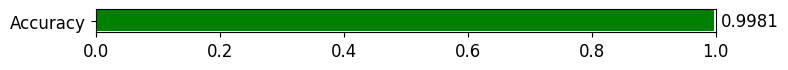

In [ ]:
plt.figure(figsize=(8, 0.3))

# Create the horizontal bar plot
plt.barh(["Accuracy"], [test_score], color="green")

# Set plot properties
plt.xlim(0, 1)  # Set the x-axis limits to represent accuracy between 0 and 1
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Add the test score value to the right of the bar
plt.text(test_score + 0.01, 0, f"{test_score:.4f}", va="center", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()